# XGBoost regression

XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is used for supervised learning problems (regression as well as classification), where we use the training data (with multiple features) to predict a target variable. 

In this tutorial we'll cover how to perform XGBoost regression in Python. We will focus on the following topics:

- XGBoost hyperparameters
- Fit and evaluate
- Feature importance
- Cross validation
- Hyperparameter tuning

## Setup

In [93]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
print("XGB Version:", xgb.__version__)

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

XGB Version: 1.5.0


## Data

We use data drawn from the 1990 U.S. Census (see this [data description](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) for more information).

### Data import

In [94]:
X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True) 

feature_names = X.columns

In [95]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


### Data splitting

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Model

### Hyperparameters

XGBoost provides many hyperparameters but we will only consider a few of them (see the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) for an complete overview). Note that we will use the [scikit-learn wrapper interface](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn):


- `objective`: determines the loss function to be used like `reg:squarederror` for regression problems, `binary:logistic` for logistic regression for binary classification or `multi:softmax`  to do multiclass classification using the softmax objectiv (note that there are more options).


- `n_estimators`: Number of gradient boosted trees. Equivalent to number of boosting rounds.


- `max_depth`: Maximum tree depth for base learners.


- `learning_rate`: Boosting learning rate (xgb’s “eta”). Range is [0,1]


- `subsample`: Subsample ratio of the training instance. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 


- `colsample_bytree`: Subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.


- `colsample_bylevel`: Subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.


- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. A higher value leads to fewer splits. 


- `reg_alpha`: L1 regularization term on weights (xgb’s alpha). A large value leads to more regularization.


- `reg_lambda`: L2 regularization term on weights (xgb’s lambda).

- `eval_metric` (default is according to objective). Evaluation metrics for validation data, a default metric will be assigned according to objective (`rmse` for regression, and `logloss` for classificationestimator
).


- `random_state`: Random number seed.

- `early_stopping_rounds`: If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. Early stopping requires at least one set in evals. If there’s more than one, it will use the last. Note that we include this parameter in our fit function.


- Define hyperparameters

In [97]:
params = {
    "objective": "reg:squarederror",
    "n_estimators":100,
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "rmse",
    "random_state": 42,
}

### Evaluation set

### Fit model

In [98]:
reg = xgb.XGBRegressor(**params)

- Prepare evaluation data:
  - If there’s more than one item in `eval_set`, the last entry will be used for early stopping.
  - If we want to plot the learning curves for both training and test data, we need to provide both training and test data as eval_set

In [99]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [100]:
reg.fit(X_train, 
        y_train, 
        verbose=False,
        eval_set= eval_set,
        early_stopping_rounds= 5
        )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation

- First, we obtain our best iteration (this attribute is 0-based, for instance if the best iteration is the 5th round, then best_iteration is 4).

In [101]:
best_iter = reg.best_iteration
best_iter

99

In [102]:
evals_result = reg.evals_result()

Show validation result for our best iteration:

In [103]:
evals_result['validation_1']['rmse'][best_iter]

0.978616

- Make predictions

In [104]:
y_pred = reg.predict(X_test)

- Obtain RMSE with skicit-learn function mean_squared_error:

In [105]:
mean_squared_error(y_test, y_pred, squared = False)

0.9786155477422379

- Save the model

In [106]:
# Save model into JSON format.
reg.save_model("regressor.json")

### Plot training test deviance


- Obtain evaluation metrics

In [107]:
results = reg.evals_result()

- Plot training test deviance

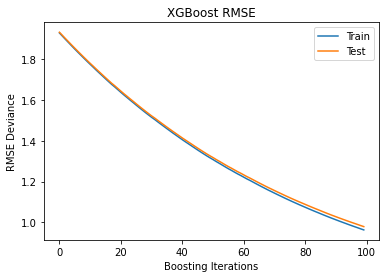

In [108]:
# Prepare x-axis
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");


## Feature importance

- Next, we take a look at the tree based feature importance and the permutation importance.

### Mean decrease in impurity (MDI)

- Mean decrease in impurity (MDI) is a measure of feature importance for decision tree models. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/mdi.html#) to learn more about MDI
```

In [109]:
reg.feature_importances_

array([0.36361885, 0.06250317, 0.16818316, 0.07790712, 0.01166479,
       0.15469895, 0.08890022, 0.07252376], dtype=float32)

- Feature importances are provided by the function `plot_importance` 

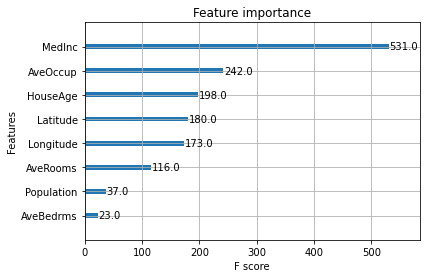

In [110]:
xgb.plot_importance(reg);

### Permutation feature importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

```{Note}
Visit [this notebook](https://kirenz.github.io/feature-engineering/docs/permutation-feature-importance.html) to learn more about permutation feature importance.
```

In [111]:

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

/Users/jankirenz/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/jankirenz/opt/anaconda3/envs/xgboost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [112]:
tree_importances = pd.Series(result.importances_mean, index=feature_names)

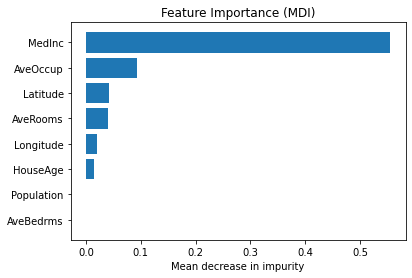

In [113]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

- Same data plotted as boxplot:

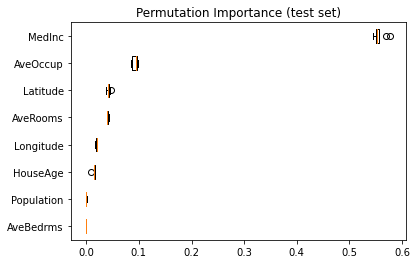

In [114]:
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

### Visualize tree

You need to install graphviz to plot the tree (for Anaconda, use `conda install python-graphviz`)

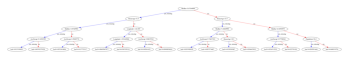

In [115]:
xgb.plot_tree(reg ,num_trees=0)

plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

## Crossvalidation

Next, we use k-fold cross validation to build even more robust trees. 

First, we will convert the dataset into an optimized data structure called Dmatrix.

In [116]:
dmatrix = xgb.DMatrix(data=X,label=y)

We use the same hyperparameteras as before. We just drop `num_estimators` and instead use `num_boost_round` in our fit.

In [117]:
params_cv = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "learning_rate": 0.01,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "rmse",
    "random_state": 42,
}

Perform cross validation:

In [118]:
reg_cv = xgb.cv(dtrain=dmatrix, 
                nfold=3,
                params=params_cv,
                num_boost_round=5,
                early_stopping_rounds=10,
                metrics="rmse", 
                as_pandas=True, 
                seed=123)

In [119]:
reg_cv.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.930837,0.008074,1.930872,0.016105
1,1.914908,0.008166,1.914989,0.015754
2,1.898777,0.008120,1.898905,0.015530
3,1.882705,0.008067,1.882887,0.015337
4,1.866842,0.007958,1.867077,0.015233


Extract and print the final boosting round metric.



In [120]:
print((reg_cv["test-rmse-mean"]).tail(1))

4    1.867077
Name: test-rmse-mean, dtype: float64


## Hyperparameter Tuning

Let's demonstrate hyperparameter tuning for only a few parameters:

In [121]:
params = { 'max_depth': [3,6],
           'learning_rate': [0.01, 0.05],
           'n_estimators': [3, 5],
           'colsample_bytree': [0.3, 0.7]}

In [122]:
reg_h = xgb.XGBRegressor(seed = 20)

In [123]:
reg_hyper = GridSearchCV(estimator=reg_h, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

In [124]:
reg_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_esti...bs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    see

In [125]:
print("Best parameters:", reg_hyper.best_params_)
print("Lowest MSE: ", (-reg_hyper.best_score_))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 5}
Lowest MSE:  2.4835107214397
